In [101]:
import boto3
import pandas as pd
import psycopg2
from io import StringIO
import glob
import os
from dotenv import load_dotenv

In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# For display
pd.set_option('display.max_columns', None)

## A. Upload CSVs to S3 (using boto3)

In [103]:
# AWS S3 Configuration
s3_client = boto3.client('s3')
bucket_name = 'medoptix'
prefix = 'datasets/'

# ✅ Correct path to your Datasets folder (adjust if needed)
local_folder = r'C:\Users\GIDI\Desktop\Folders\REPOSITORY\medoptix-ai-internship\Datasets'
csv_files = glob.glob(os.path.join(local_folder, '*.csv'))

print("🔍 Found CSV files:", csv_files)

for file_path in csv_files:
    try:
        file_name = os.path.basename(file_path)
        s3_key = f"{prefix}{file_name}"
        
        s3_client.upload_file(file_path, bucket_name, s3_key)
        print(f"✅ Uploaded: {file_name} to s3://{bucket_name}/{s3_key}")
    except Exception as e:
        print(f"❌ Failed to upload {file_name}: {e}")


🔍 Found CSV files: ['C:\\Users\\GIDI\\Desktop\\Folders\\REPOSITORY\\medoptix-ai-internship\\Datasets\\clinics.csv', 'C:\\Users\\GIDI\\Desktop\\Folders\\REPOSITORY\\medoptix-ai-internship\\Datasets\\dropout_flags.csv', 'C:\\Users\\GIDI\\Desktop\\Folders\\REPOSITORY\\medoptix-ai-internship\\Datasets\\feedback.csv', 'C:\\Users\\GIDI\\Desktop\\Folders\\REPOSITORY\\medoptix-ai-internship\\Datasets\\interventions.csv', 'C:\\Users\\GIDI\\Desktop\\Folders\\REPOSITORY\\medoptix-ai-internship\\Datasets\\patients.csv', 'C:\\Users\\GIDI\\Desktop\\Folders\\REPOSITORY\\medoptix-ai-internship\\Datasets\\sessions.csv']
✅ Uploaded: clinics.csv to s3://medoptix/datasets/clinics.csv
✅ Uploaded: dropout_flags.csv to s3://medoptix/datasets/dropout_flags.csv
✅ Uploaded: feedback.csv to s3://medoptix/datasets/feedback.csv
✅ Uploaded: interventions.csv to s3://medoptix/datasets/interventions.csv
✅ Uploaded: patients.csv to s3://medoptix/datasets/patients.csv
✅ Uploaded: sessions.csv to s3://medoptix/datasets/

## B. Load from S3 → PostgreSQL


In [104]:
import pandas as pd
from sqlalchemy import create_engine
import boto3

s3 = boto3.client("s3")


bucket = "medoptix"
prefix = "datasets/"

# Files to download
files = ["patients.csv", "clinics.csv", "sessions.csv", "feedback.csv", "dropout_flags.csv"]

# Download files
for file in files:
    s3.download_file(bucket, prefix + file, file)
    print(f"⬇️ Downloaded {file} from S3")



⬇️ Downloaded patients.csv from S3
⬇️ Downloaded clinics.csv from S3
⬇️ Downloaded sessions.csv from S3
⬇️ Downloaded feedback.csv from S3
⬇️ Downloaded dropout_flags.csv from S3


# Data Modelling & Defining Foreign Key relationships


- patients (PK: patient_id)
- sessions (PK: session_id, FK: patient_id)
- feedback (PK: feedback_id, FK: session_id)


TASK 1 - Model and Define the relationship for the remaining set of dataset
 - clinics
 - dropout_flags
 - intervention.csv

TASK 2 - Create Schema for these dataset and upload then into postgres

## C. Upload Data → PostgreSQL


In [105]:
# PostgreSQL Configuration
db_params = {
    "host": os.getenv("DB_HOST"),
    "port": os.getenv("DB_PORT"),
    "dbname": os.getenv("DB_NAME"),
    "user": os.getenv("DB_USER"),
    "password": os.getenv("DB_PASSWORD"),
    "sslmode": os.getenv("DB_SSLMODE")
}

In [106]:
import pandas as pd
from sqlalchemy import create_engine
import os
from dotenv import load_dotenv

# Load environment variables (recommended for security)
load_dotenv()

def get_db_engine():
    """Create and return a SQLAlchemy engine with proper connection string"""
    # Construct connection string from environment variables
    db_url = (
        f"postgresql://{''}:{''}@"
        f"{''}:{''}/{''}?"
    )
    return create_engine(db_url)

def upload_data():
    # Step 1: Read CSV files
    patients = pd.read_csv("medoptix_data\processed\patients.csv")
    sessions = pd.read_csv("medoptix_data\processed\sessions.csv")
    feedback = pd.read_csv("C:/Users/Muham/Downloads/Medoptix_Demo/medoptix_data/processed/feedback.csv")

    # Step 2: Create database engine
    engine = get_db_engine()

    # Step 3: Upload in referential order with error handling
    with engine.begin() as connection:  # Automatically handles transactions
        # Chunk size for large datasets (adjust as needed)
        chunk_size = 1000

        # Upload patients table
        patients.to_sql(
            "patients", 
            connection, 
            if_exists="append", 
            index=False,
            chunksize=chunk_size,
            method='multi'  # Faster for bulk inserts
        )

        # Upload sessions table
        sessions.to_sql(
            "sessions", 
            connection, 
            if_exists="append", 
            index=False,
            chunksize=chunk_size,
            method='multi'
        )

        # Upload feedback table
        feedback.to_sql(
            "feedback", 
            connection, 
            if_exists="append", 
            index=False,
            chunksize=chunk_size,
            method='multi'
        )

    print("✅ Data uploaded successfully with relationships intact.")

if __name__ == "__main__":
    upload_data()

FileNotFoundError: [Errno 2] No such file or directory: 'medoptix_data\\processed\\patients.csv'

## D. Read Data → PostgreSQL - (Prepare data for EDA)


In [ ]:
from sqlalchemy import create_engine
import pandas as pd


def get_db_engine():
    """Create and return a SQLAlchemy engine with proper connection string"""
    # Construct connection string from environment variables
    db_url = (
        f"postgresql://{''}:{''}@"
        f"{''}:{''}/{''}?"
    )
    return create_engine(db_url)


engine = get_db_engine()


# Query to fetch data from the tables
patients_query = "SELECT * FROM patients"
sessions_query = "SELECT * FROM sessions"
feedback_query = "SELECT * FROM feedback"

# Load data into pandas DataFrame
patients_df = pd.read_sql(patients_query, engine)
sessions_df = pd.read_sql(sessions_query, engine)
feedback_df = pd.read_sql(feedback_query, engine)




In [ ]:
patients_df = pd.read_csv(r'C:\Users\GIDI\Desktop\Folders\REPOSITORY\medoptix-ai-internship\Datasets\patients.csv')
sessions_df = pd.read_csv(r'C:\Users\GIDI\Desktop\Folders\REPOSITORY\medoptix-ai-internship\Datasets\sessions.csv')
feedback_df = pd.read_csv(r'C:\Users\GIDI\Desktop\Folders\REPOSITORY\medoptix-ai-internship\Datasets\feedback.csv')
clinics_df =pd.read_csv(r'C:\Users\GIDI\Desktop\Folders\REPOSITORY\medoptix-ai-internship\Datasets\clinics.csv')
interventions_df =pd.read_csv(r'C:\Users\GIDI\Desktop\Folders\REPOSITORY\medoptix-ai-internship\Datasets\interventions.csv')
drop_df = pd.read_csv(r'C:\Users\GIDI\Desktop\Folders\REPOSITORY\medoptix-ai-internship\Datasets\dropout_flags.csv')


## E. EDA → (Exploratory Data Analysis)

Steps in EDA
 - Data Exploration
    - Head()
    - info()
    - describe()
 - Data Cleaning 
    - Identifying & Handling Missing Values
    - Identifying & Handling Duplicates
 - Data Transformation (Feature Engineering)
   - Standardizing data types (text, date, replacing values)
   - Log Transform (for highly skewed data e.g., income, prices)
   - Binning (Convert continuous variables into categorical bins e.g., age ranges)
   - Encoding (Convert categorical variables into numerical format (e.g., One-Hot, Label Encoding))
 - Data Distributions
    - Histograms for distributions of numerical features (age, bmi etc)- Also to check if the features are normally distributed or skewed (e.g., pain level or age should be somewhat evenly distributed just like we discovered in the last drop-in session).
    - Boxplots to detect outliers & handle them.
    - Pairplots to visualize relationships between multiple features.
 -  Correlation Analysis (dentify relationships between variables that may help in predictive modeling)
    - Correlation Matrix to understand feature dependencies.
    - Heatmap for visual representation of correlations.
 - Understanding Dropout Behavior
    - investigate the correlation between features and patient dropout.



In [ ]:
patients_df.head()

,patient_id,age,gender,bmi,smoker,chronic_cond,injury_type,signup_date,referral_source,consent,clinic_id,insurance_type
0,1,29,Male,23.9,False,NaN,Knee,2025-04-27 00:12:44,Insurance,True,6,Public
1,2,68,Female,31.7,True,NaN,Shoulder,2024-11-28 00:12:44,Insurance,False,3,Public
2,3,64,Male,27.5,False,NaN,Hip,2024-10-10 00:12:44,GP,True,5,Public
3,4,41,Female,26.1,False,NaN,Back,2024-12-12 00:12:44,GP,True,2,Private-Premium
4,5,22,Female,21.3,False,NaN,Shoulder,2025-03-28 00:12:44,Insurance,True,4,Private-Basic


# Inspection and Data Cleaning

In [ ]:
patients_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   patient_id       5000 non-null   int64  
 1   age              5000 non-null   int64  
 2   gender           5000 non-null   object 
 3   bmi              5000 non-null   float64
 4   smoker           5000 non-null   bool   
 5   chronic_cond     1931 non-null   object 
 6   injury_type      5000 non-null   object 
 7   signup_date      5000 non-null   object 
 8   referral_source  5000 non-null   object 
 9   consent          5000 non-null   bool   
 10  clinic_id        5000 non-null   int64  
 11  insurance_type   5000 non-null   object 
dtypes: bool(2), float64(1), int64(3), object(6)
memory usage: 400.5+ KB


There are some missing values in chronic_cond. Actually the missing values are those with no chronic disease

In [ ]:
if pd.api.types.is_categorical_dtype(patients_df['chronic_cond']):
    patients_df['chronic_cond'] = patients_df['chronic_cond'].cat.add_categories(['No chronic'])

# Then, fill NaN values with "No chronic"
patients_df['chronic_cond'] = patients_df['chronic_cond'].fillna('No chronic')

C:\Users\GIDI\AppData\Local\Temp\ipykernel_10368\1953104510.py:1: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(patients_df['chronic_cond']):


In [ ]:
# Check unique elements in each column and print them out
for column in patients_df.columns:
    unique_values = patients_df[column].unique()
    print(f"Unique values in '{column}':\n{unique_values}\n")

Unique values in 'patient_id':
[   1    2    3 ... 4998 4999 5000]

Unique values in 'age':
[29 68 64 41 22 83 47 77 63 70 31 42 49 51 20 54 28 67 79 82 45 39 78 23
 71 30 26 40 33 55 62 81 73 60 24 38 69 74 43 37 34 27 18 65 36 48 56 25
 61 75 58 32 84 21 46 72 19 66 80 35 57 59 50 52 53 76 44]

Unique values in 'gender':
['Male', 'Female']
Categories (2, object): ['Female', 'Male']

Unique values in 'bmi':
[23.9 31.7 27.5 26.1 21.3 19.4 29.5 27.3 18.1 32.6 28.9 22.  21.6 21.7
 23.1 25.4 24.4 23.  26.2 21.  23.8 24.7 28.2 21.9 25.3 26.  19.  21.5
 19.5 31.6 32.3 28.6 20.3 27.  24.5 20.7 25.1 18.7 30.4 22.6 26.8 23.2
 25.6 32.5 28.1 31.2 30.1 30.7 20.1 21.8 23.4 24.  22.8 23.7 22.9 25.5
 28.5 19.8 33.9 17.4 28.7 28.  20.6 29.4 26.3 26.5 29.9 24.8 27.9 25.7
 18.3 20.5 18.6 25.2 22.5 24.2 27.8 22.3 30.9 29.6 30.  23.3 22.2 24.3
 23.5 31.4 27.2 32.7 32.2 19.2 22.4 21.1 25.  33.8 26.9 26.4 29.  18.9
 17.9 26.6 27.1 30.8 29.7 26.7 20.2 30.2 23.6 20.  17.6 17.3 27.7 29.2
 25.8 22.7 24.1 28.4

In [ ]:
# Convert object columns to 'category' type
category_columns = ['consent', 'clinic_id','insurance_type','referral_source','injury_type',
                    'chronic_cond','smoker','gender']
for col in category_columns:
    patients_df[col] = patients_df[col].astype('category')

# Convert date columns to datetime
date_columns = ['signup_date']

for col in date_columns:
    patients_df[col] = pd.to_datetime(patients_df[col])

# Check the updated data types
patients_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   patient_id       5000 non-null   int64         
 1   age              5000 non-null   int64         
 2   gender           5000 non-null   category      
 3   bmi              5000 non-null   float64       
 4   smoker           5000 non-null   category      
 5   chronic_cond     5000 non-null   category      
 6   injury_type      5000 non-null   category      
 7   signup_date      5000 non-null   datetime64[ns]
 8   referral_source  5000 non-null   category      
 9   consent          5000 non-null   category      
 10  clinic_id        5000 non-null   category      
 11  insurance_type   5000 non-null   category      
dtypes: category(8), datetime64[ns](1), float64(1), int64(2)
memory usage: 196.9 KB


In [ ]:
#checking for duplicates
patients_df.duplicated().sum()

0

#### F-2 Binning (putting the age into categories)

In [ ]:
import numpy as np
# Add age group column for segmentation
bins = [0, 18, 35, 55, np.inf]
labels = ['0-18', '19-35', '36-55', '55+']
patients_df['age_group'] = pd.cut(patients_df['age'], bins=bins, labels=labels)
patients_df.head(2)

,patient_id,age,gender,bmi,smoker,chronic_cond,injury_type,signup_date,referral_source,consent,clinic_id,insurance_type,age_group
0,1,29,Male,23.9,False,No chronic,Knee,2025-04-27 00:12:44,Insurance,True,6,Public,19-35
1,2,68,Female,31.7,True,No chronic,Shoulder,2024-11-28 00:12:44,Insurance,False,3,Public,55+


F-3 : TASK 4 (Data Transformation)
- Log Transform (for highly skewed data e.g., income, prices)
- Encoding (Convert categorical variables into numerical format (e.g., One-Hot, Label Encoding))

In [ ]:
patients_df.describe()

,patient_id,age,bmi,signup_date,clinic_id
count,5000.000000,5000.000000,5000.000000,5000,5000.000000
mean,2500.500000,50.907200,25.174580,2024-12-10 09:48:44,3.387800
min,1.000000,18.000000,17.000000,2024-06-13 00:12:44,1.000000
25%,1250.750000,34.000000,22.400000,2024-09-08 00:12:44,2.000000
50%,2500.500000,51.000000,25.100000,2024-12-10 12:12:44,3.000000
75%,3750.250000,68.000000,27.700000,2025-03-11 00:12:44,5.000000
max,5000.000000,84.000000,38.800000,2025-06-12 00:12:44,8.000000
std,1443.520003,19.403203,3.769633,NaN,1.749521


Minimal level of skewness

# G. Data Distribution 

#### G-1  Boxplot for distributions of numerical features

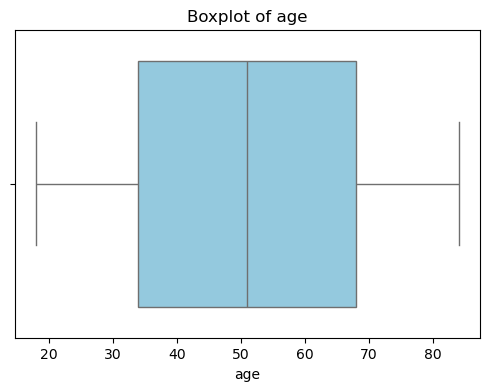

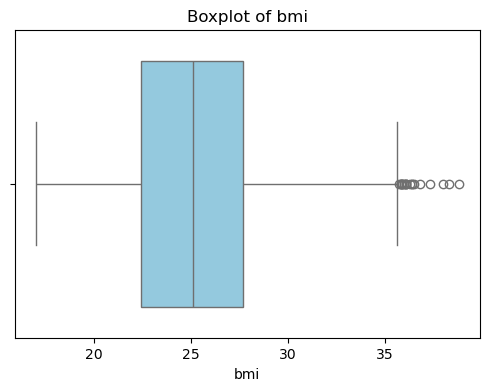

In [ ]:
# List of numerical columns
numerical_cols = ['age', 'bmi']

for col in numerical_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=patients_df[col], color='skyblue')
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)
    plt.show()

#### G-2  TASK 5 (Data Distribution)
- Boxplots to detect outliers & handle them.
- Pairplots to visualize relationships between multiple features.

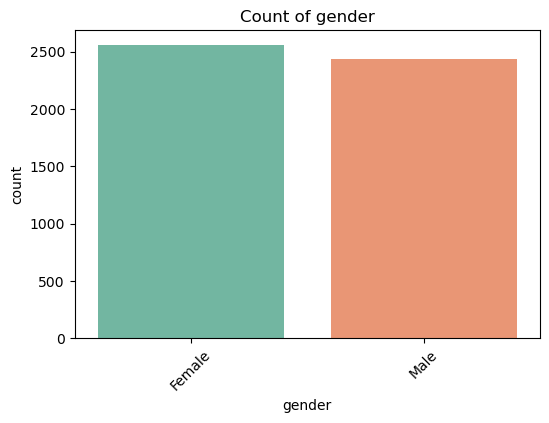

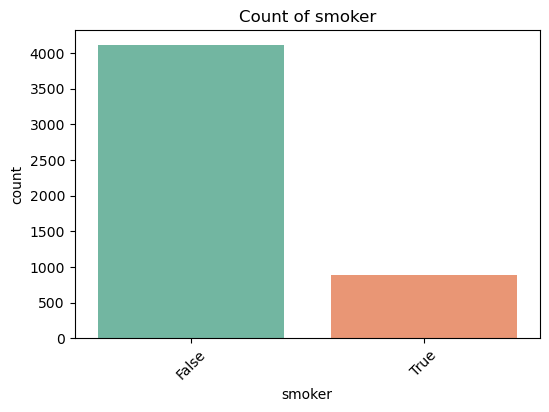

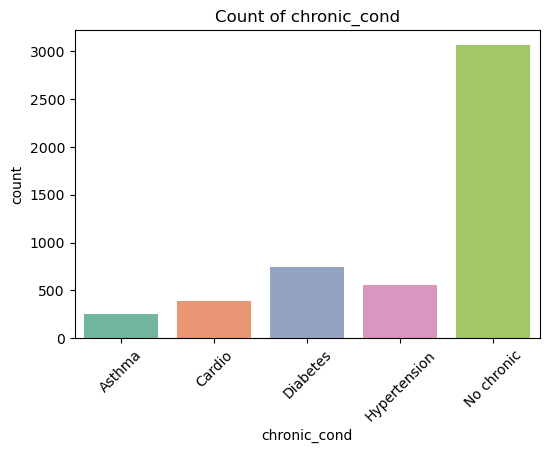

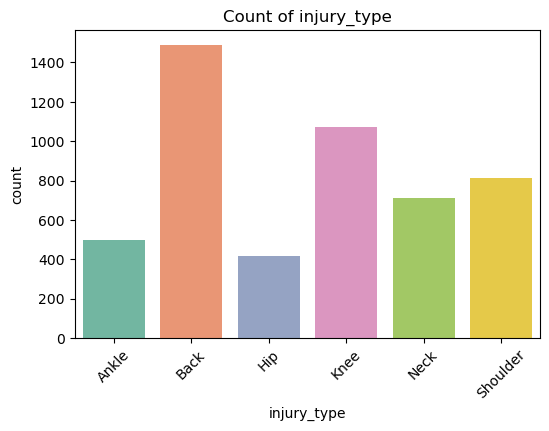

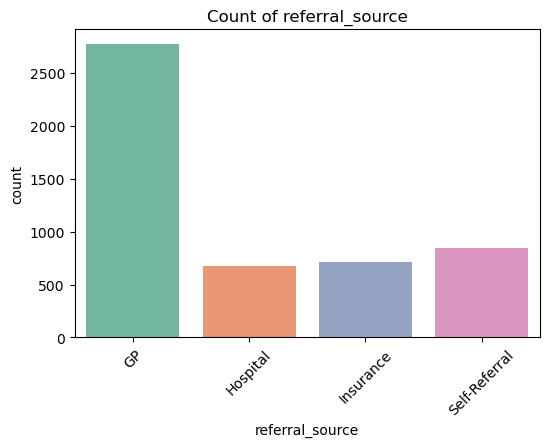

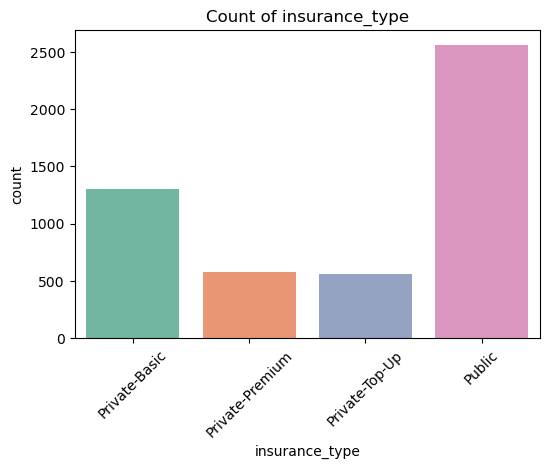

In [ ]:
categorical_cols = ['gender', 'smoker', 'chronic_cond', 'injury_type', 'referral_source', 'insurance_type']

for col in categorical_cols:
    plt.figure(figsize=(6, 4))
    sns.countplot(data=patients_df, x=col, palette='Set2')
    plt.title(f'Count of {col}')
    plt.xticks(rotation=45)
    plt.show()


# Feature Engineering

In [ ]:
# Signup features
patients_df['signup_month'] = patients_df['signup_date'].dt.month
patients_df['signup_dayofweek'] = patients_df['signup_date'].dt.day_name()

# BMI categories
patients_df['bmi_category'] = pd.cut(patients_df['bmi'],
                                     bins=[0, 18.5, 24.9, 29.9, 100],
                                     labels=['Underweight', 'Normal', 'Overweight', 'Obese'])

# Chronic condition binary
patients_df['has_chronic_cond'] = patients_df['chronic_cond'].apply(lambda x: 0 if x == 'No chronic' else 1)

# H. CORRELATION ANALYSIS

#### H-1 TASK 6 (Correlation Analysis)

-  Correlation Analysis (dentify relationships between variables that may help in predictive modeling)
- Correlation Matrix to understand feature dependencies.
- Heatmap for visual representation of correlations.

In [ ]:
from sklearn.preprocessing import LabelEncoder

# List of multi-class categorical features
multi_class_cols = ['chronic_cond', 'injury_type', 'referral_source', 'insurance_type',
                     'clinic_id','smoker','consent','gender','signup_dayofweek','bmi_category']

# Apply Label Encoding
le = LabelEncoder()
for col in multi_class_cols:
    patients_df[col] = le.fit_transform(patients_df[col])

In [ ]:
patients_df

,patient_id,age,gender,bmi,smoker,chronic_cond,injury_type,signup_date,referral_source,consent,clinic_id,insurance_type,age_group,signup_month,signup_dayofweek,bmi_category,has_chronic_cond
0,1,29,1,23.9,0,4,3,2025-04-27 00:12:44,2,1,5,3,19-35,4,3,0,0
1,2,68,0,31.7,1,4,5,2024-11-28 00:12:44,2,0,2,3,55+,11,4,1,0
2,3,64,1,27.5,0,4,2,2024-10-10 00:12:44,0,1,4,3,55+,10,4,2,0
3,4,41,0,26.1,0,4,1,2024-12-12 00:12:44,0,1,1,1,36-55,12,4,2,0
4,5,22,0,21.3,0,4,5,2025-03-28 00:12:44,2,1,3,0,19-35,3,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4996,33,0,30.1,1,2,1,2024-11-05 00:12:44,3,1,3,0,19-35,11,5,1,1
4996,4997,79,0,20.7,0,4,5,2024-09-14 00:12:44,3,1,1,0,55+,9,2,0,0
4997,4998,54,0,23.4,0,4,1,2025-02-28 00:12:44,0,1,0,3,36-55,2,0,0,0
4998,4999,84,1,28.7,0,4,3,2024-06-17 00:12:44,0,1,2,3,55+,6,1,2,0


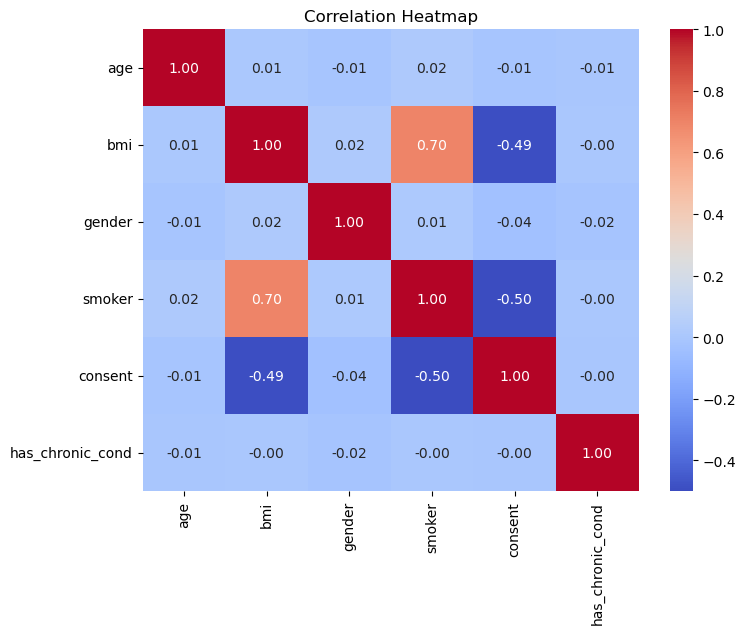

In [ ]:
# Select only numerical columns for correlation
corr_df = patients_df[['age', 'bmi', 'gender', 'smoker', 'consent', 'has_chronic_cond']]

plt.figure(figsize=(8, 6))
sns.heatmap(corr_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()


# Clustering Analysis

In [ ]:
sessions_df.head()

,session_id,patient_id,date,week,duration,pain_level,exercise_type,home_adherence_pc,satisfaction,therapist_id
0,315291cb2a5c4c29a65810cd5ec7dcb4,1,2025-05-02 00:12:44,1,40,6,Balance,51,6,1162
1,2a62e7445d3f43b8849a514a0c27210a,1,2025-04-30 00:12:44,1,59,6,Hydrotherapy,100,7,1022
2,5437794f3f3246ca8e582b983e9d9766,1,2025-05-08 00:12:44,2,33,4,Stretching,80,6,1010
3,e0c78ac4bd6a4ed8b02c10ee0ae11348,1,2025-05-05 00:12:44,2,44,4,Ultrasound,85,8,1161
4,3940a79f93934154a4c4072b1079a136,1,2025-05-14 00:12:44,3,58,4,Stretching,44,3,1185


# Feature Engineering from sessions_df

In [ ]:
# Convert date
sessions_df['date'] = pd.to_datetime(sessions_df['date'])

# Sort
sessions_df = sessions_df.sort_values(['patient_id', 'date'])

# Group by patient and engineer session-level features
progress_summary = sessions_df.groupby('patient_id').agg({
    'pain_level': ['first', 'last', 'mean'],
    'satisfaction': 'mean',
    'home_adherence_pc': ['mean', 'std'],
    'duration': 'mean',
    'week': 'nunique'  # to get engagement span
})

# Flatten multi-index columns
progress_summary.columns = ['_'.join(col).strip() for col in progress_summary.columns.values]
progress_summary = progress_summary.reset_index()

# Derived features
progress_summary['pain_delta'] = progress_summary['pain_level_first'] - progress_summary['pain_level_last']
progress_summary['pain_pct_change'] = (
    progress_summary['pain_delta'] / progress_summary['pain_level_first'].replace(0, np.nan)
).fillna(0)

progress_summary.rename(columns={
    'home_adherence_pc_mean': 'avg_home_adherence',
    'home_adherence_pc_std': 'adherence_variability',
    'duration_mean': 'avg_session_duration',
    'satisfaction_mean': 'avg_satisfaction',
    'week_nunique': 'active_weeks'
}, inplace=True)

progress_summary.head()

,patient_id,pain_level_first,pain_level_last,pain_level_mean,avg_satisfaction,avg_home_adherence,adherence_variability,avg_session_duration,active_weeks,pain_delta,pain_pct_change
0,1,6,1,2.150000,6.500000,77.750000,19.983875,41.750000,12,5,0.833333
1,2,5,1,2.250000,7.000000,61.625000,12.682243,33.875000,5,4,0.800000
2,3,6,1,2.470588,5.941176,73.705882,13.873377,41.470588,11,5,0.833333
3,4,6,1,2.000000,6.647059,69.764706,15.176171,47.588235,12,5,0.833333
4,5,5,1,2.333333,6.416667,73.666667,14.742230,33.833333,8,4,0.800000


# Merge sessions and patients datasets

In [ ]:
# Merge with patient demographic/clinical info
full_df = pd.merge(patients_df, progress_summary, on='patient_id', how='inner')

# Drop any columns not needed or redundant
selected_cols = [
    'age', 'bmi', 'smoker', 'gender', 'consent',
    'pain_delta', 'pain_pct_change', 'avg_home_adherence',
    'adherence_variability', 'avg_satisfaction',
    'avg_session_duration', 'active_weeks'
]

# Standardize
from sklearn.preprocessing import StandardScaler
X = full_df[selected_cols].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# K means clustering

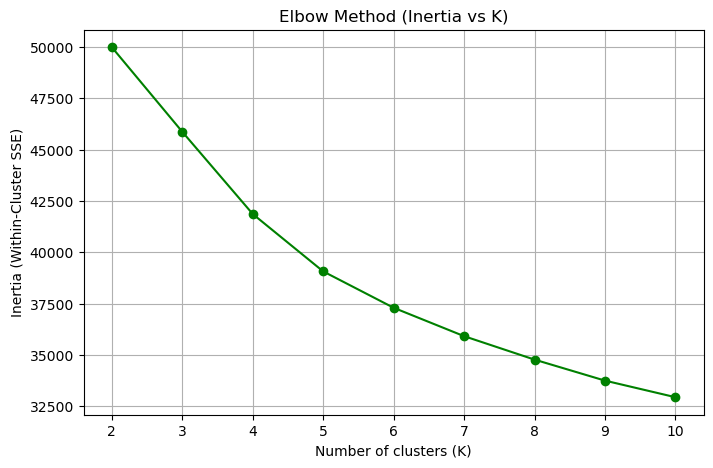

In [100]:
inertias = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, inertias, marker='o', color='green')
plt.title("Elbow Method (Inertia vs K)")
plt.xlabel("Number of clusters (K)")
plt.ylabel("Inertia (Within-Cluster SSE)")
plt.grid(True)
plt.show()


In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
full_df['cluster'] = kmeans.fit_predict(X_scaled)

In [ ]:
cluster_summary = full_df.groupby('cluster')[selected_cols].mean().round(2)
cluster_summary

,age,bmi,smoker,gender,consent,pain_delta,pain_pct_change,avg_home_adherence,adherence_variability,avg_satisfaction,avg_session_duration,active_weeks
cluster,,,,,,,,,,,,
0,50.77,23.92,0.0,0.0,1.00,4.02,0.79,69.33,14.56,6.49,39.57,9.71
1,51.75,30.85,1.0,0.5,0.71,3.59,0.75,69.39,14.52,6.48,39.57,7.63
2,50.68,23.99,0.0,1.0,1.00,4.08,0.79,69.30,14.64,6.50,39.45,9.78


In [ ]:
persona_map = {
    0: 'Fast Improvers',
    1: 'Frustrated Droppers',
    2: 'Steady Progressors'
}

full_df['persona'] = full_df['cluster'].map(persona_map)


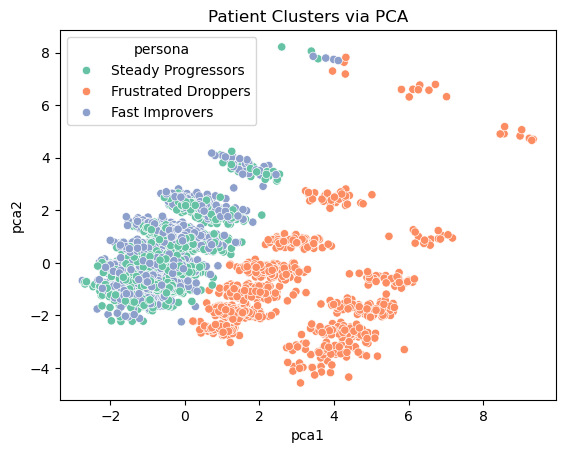

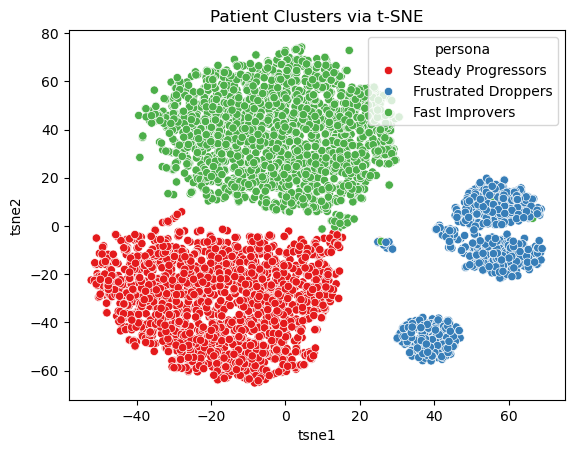

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


# PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)
full_df['pca1'], full_df['pca2'] = pca_result[:, 0], pca_result[:, 1]

sns.scatterplot(data=full_df, x='pca1', y='pca2', hue='persona', palette='Set2')
plt.title('Patient Clusters via PCA')
plt.show()

# t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(X_scaled)
full_df['tsne1'], full_df['tsne2'] = tsne_result[:, 0], tsne_result[:, 1]

sns.scatterplot(data=full_df, x='tsne1', y='tsne2', hue='persona', palette='Set1')
plt.title('Patient Clusters via t-SNE')
plt.show()

# Clusters Overview

##  Cluster 0 – Fast Improvers
 **Description**: Female, non-smokers, highly committed.

 **Traits**:
- Great pain reduction (4.02)
- High engagement (9.71 weeks)
- Excellent consent rate (1.00)

Likely to follow therapy closely and recover fast.

---

##  Cluster 1 – Frustrated Droppers
 **Description**: Mixed gender, all smokers, less compliant.

 **Traits**:
- Lowest engagement (7.63 weeks)
- Slightly lower pain reduction
- Lowest consent rate

 These are at risk of dropping out and may need extra motivation, education, or support.

---

##  Cluster 2 – Steady Progressors
 **Description**: Male, non-smokers, committed and consistent.

 **Traits**:
- Highest pain improvement (4.08)
- Longest engagement
- Consistent behavior

 Likely to succeed with gradual, methodical progress. Excellent candidates for long-term treatment plans.

---

##  Recommendations

| **Persona**            | **Actionable Strategy**                                                   |
|-----------------------|--------------------------------------------------------------------------|
| Fast Improvers        | Continue support, offer referral incentives or early discharge           |
| Frustrated Droppers   | Introduce motivational counseling, adherence reminders, and explore reasons for dropout (e.g., pain tolerance, smoking risk) |
| Steady Progressors     | Reward consistency, provide ongoing progress tracking and feedback loops  |

In [ ]:
from sklearn.metrics import silhouette_score

# silhouette score
score = silhouette_score(X_scaled, full_df['cluster'])

print(f'Silhouette Score for KMeans clustering: {score:.4f}')


Silhouette Score for KMeans clustering: 0.1139


# DBSCAN

In [114]:
from sklearn.cluster import DBSCAN

# You may need to tune eps and min_samples
dbscan = DBSCAN(eps=2, min_samples=4)
full_df['dbscan_cluster'] = dbscan.fit_predict(X_scaled)

In [115]:
dbscan_summary = full_df[full_df['dbscan_cluster'] != -1].groupby('dbscan_cluster').agg({
    'pain_delta': 'mean',
    'pain_pct_change': 'mean',
    'avg_home_adherence': 'mean',
    'adherence_variability': 'mean',
    'avg_satisfaction': 'mean',
    'active_weeks': 'mean',
    'gender': 'mean',
    'smoker': 'mean',
    'consent': 'mean'
}).round(2)

dbscan_summary


,pain_delta,pain_pct_change,avg_home_adherence,adherence_variability,avg_satisfaction,active_weeks,gender,smoker,consent
dbscan_cluster,,,,,,,,,
0,4.13,0.79,69.30,14.63,6.50,9.87,1.0,0.0,1.0
1,4.07,0.79,69.33,14.56,6.48,9.78,0.0,0.0,1.0
2,3.98,0.79,69.53,14.62,6.45,8.33,0.0,1.0,1.0
3,3.99,0.79,68.50,14.25,6.47,7.39,1.0,1.0,0.0
4,3.88,0.78,69.20,14.63,6.50,8.31,1.0,1.0,1.0
5,3.17,0.75,69.38,13.79,6.64,6.97,0.0,1.0,0.0
6,1.08,0.50,69.94,13.99,6.45,8.85,0.0,0.0,1.0
7,1.00,0.50,72.49,13.37,6.91,8.67,0.0,0.0,1.0
8,5.50,0.84,68.17,13.06,6.36,8.17,0.0,1.0,0.0


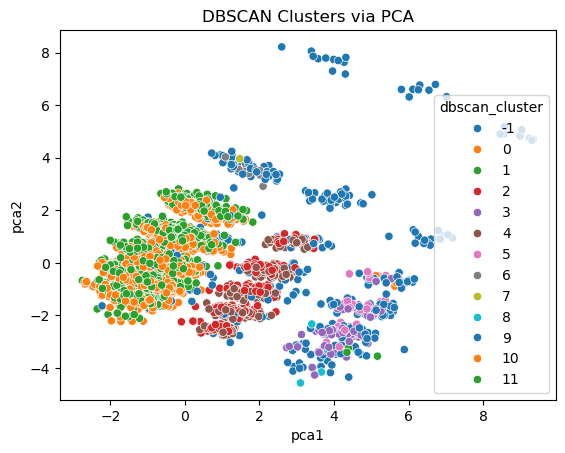

In [ ]:
sns.scatterplot(data=full_df, x='pca1', y='pca2', hue='dbscan_cluster', palette='tab10')
plt.title('DBSCAN Clusters via PCA')
plt.show()

In [113]:
from sklearn.cluster import DBSCAN

# Try increasing eps
dbscan = DBSCAN(eps=2.0, min_samples=4)
full_df['dbscan_cluster'] = dbscan.fit_predict(X_scaled)

# Recount noise points
print("Noise points:", (full_df['dbscan_cluster'] == -1).sum())


Noise points: 383
